In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import processing_netcdf as pcdf
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely.geometry 
import numpy as np
from shapely import geometry as gmty
from geofeather import to_geofeather, from_geofeather
import glob
import os
import pyarrow
from xclim import ensembles as ens
from xclim import subset
import matplotlib.pyplot as plt

In [2]:
folder = "/scen3/scenario/netcdf/ouranos/portraits-clim-2.0/"

# Select and open Region (Shapefile)

In [93]:
######Select Region by uncommenting
#region = 'DDE_STF_20K_REG_FOR_VUE_S'
# region = 'DDE_STF_20K_UA_PER_VUE_S'
#region = 'DOM_BIO'
#region = 'REG_ECO'
#region = 'SDOM_BIO'
#region = 'Secteurs_Operations_Regionales'
#region = 'SREG_ECO'
region = 'territoire_guide'

In [94]:
shapefile = ("/home/mlopez/EXEC/Shapefiles/"+region+".shp")
poly0 = gpd.read_file(shapefile)
poly = poly0[poly0.geometry.type == 'Polygon'].to_crs('epsg:4326')
poly.head()

,TER_GUIDE,geometry
1,2a,"POLYGON ((-76.08748 46.47438, -76.08807 46.475..."
3,2c,"POLYGON ((-72.38130 45.65191, -72.38112 45.652..."
4,3ab,"POLYGON ((-79.06541 47.29977, -79.06474 47.299..."
5,3c,"POLYGON ((-72.11272 47.05779, -72.11182 47.058..."
6,3d,"POLYGON ((-69.62478 47.06785, -69.62615 47.066..."


## Import dataframe with polygons

In [95]:
dfpolyshape = from_geofeather('/home/mlopez/EXEC/Grids-polygons-regions/Grid-'+region+'.feather')
#dfpolyshape = from_geofeather('/home/mlopez/EXEC/Grids-polygons-regions/Grid-.feather')

  warnings.warn(



In [96]:
dfpolyshape

,lat,lon,TER_GUIDE,geometry
0,52.957191,-67.712730,6opqr,"POLYGON ((-67.67107 52.93424, -67.67107 52.915..."
1,52.957191,-67.629402,6opqr,"POLYGON ((-67.67107 52.91553, -67.67107 52.934..."
2,52.957191,-67.546066,6opqr,"POLYGON ((-67.56730 52.91553, -67.57974 52.915..."
3,52.873859,-67.796059,6opqr,"POLYGON ((-67.75439 52.89329, -67.75439 52.832..."
4,52.873859,-67.712730,6opqr,"POLYGON ((-67.75439 52.83219, -67.75439 52.893..."
...,...,...,...,...
33193,45.041668,-72.208336,2c,"POLYGON ((-72.25000 45.00450, -72.25000 45.083..."
33194,45.041668,-72.125000,2c,"POLYGON ((-72.16666 45.00508, -72.16666 45.083..."
33195,45.041668,-72.041672,2c,"POLYGON ((-72.08334 45.00564, -72.08334 45.083..."
33196,45.041668,-71.958336,2c,"POLYGON ((-72.00000 45.00667, -72.00000 45.083..."


# Select variable

In [21]:
#Variable 
variable85="rcp85_tg_mean_annual"
variable45="rcp85_tg_mean_annual"
#variable="rcp[48]5_tg_mean_annual"

files85 = glob.glob(folder+"*"+variable85+".nc")
files45 = glob.glob(folder+"*"+variable45+".nc")
#ex: ACCESS1-3_rcp45_tn_mean_annual.nc
files85
files45

['/scen3/scenario/netcdf/ouranos/portraits-clim-2.0/ACCESS1-3_rcp85_tg_mean_annual.nc',
 '/scen3/scenario/netcdf/ouranos/portraits-clim-2.0/BNU-ESM_rcp85_tg_mean_annual.nc',
 '/scen3/scenario/netcdf/ouranos/portraits-clim-2.0/CanESM2_rcp85_tg_mean_annual.nc',
 '/scen3/scenario/netcdf/ouranos/portraits-clim-2.0/CMCC-CMS_rcp85_tg_mean_annual.nc',
 '/scen3/scenario/netcdf/ouranos/portraits-clim-2.0/GFDL-ESM2M_rcp85_tg_mean_annual.nc',
 '/scen3/scenario/netcdf/ouranos/portraits-clim-2.0/HadGEM2-CC_rcp85_tg_mean_annual.nc',
 '/scen3/scenario/netcdf/ouranos/portraits-clim-2.0/INM-CM4_rcp85_tg_mean_annual.nc',
 '/scen3/scenario/netcdf/ouranos/portraits-clim-2.0/IPSL-CM5A-LR_rcp85_tg_mean_annual.nc',
 '/scen3/scenario/netcdf/ouranos/portraits-clim-2.0/IPSL-CM5B-LR_rcp85_tg_mean_annual.nc',
 '/scen3/scenario/netcdf/ouranos/portraits-clim-2.0/MPI-ESM-LR_rcp85_tg_mean_annual.nc',
 '/scen3/scenario/netcdf/ouranos/portraits-clim-2.0/NorESM1-M_rcp85_tg_mean_annual.nc']

# FOR RCP 45

## Open Mask if already created or create it. 

In [97]:
dsEns45= ens.create_ensemble(files45)
#dsEnsSeas = ens.create_ensemble(filesSeas)
dsEns45
if os.path.exists(shapefile.replace('.shp','.nc')):
    mask = xr.open_dataset(shapefile.replace('.shp','.nc'))
    mask = mask.__xarray_dataarray_variable__
    
else:
    mask= subset.create_mask(poly=poly, x_dim=dsEns45.lon, y_dim=dsEns45.lat)
    mask = mask.T
    mask.to_netcdf(shapefile.replace('.shp','.nc'))

  warn(



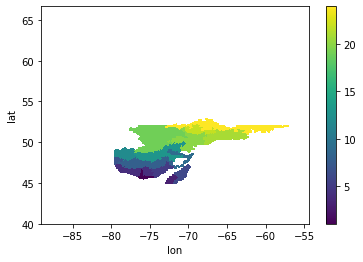

In [98]:
mask.plot()

## Subsetting arrays by periods of time and percentiles with Xclim

In [101]:
# Mapping data - 30 year means
tmp1 = dsEns45.sel(time=(dsEns45.time.dt.year>=1981))
window = 30
time1 = tmp1.time[0::window]

ds30yavg = tmp1.coarsen(time=window).mean()
ds30yavg['time'] = time1
perc30yavg = ens.ensemble_percentiles(ds30yavg)
perc30yavg # entire grid

# Mapping data

<xarray.Dataset>
Dimensions:      (lat: 320, lon: 416, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 66.62331 66.53998 66.45665 ... 40.12437 40.04104
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -89.04521 -88.96188 ... -54.54659 -54.46326
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 320, 416), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 320, 416), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 320, 416), meta=np.ndarray>

In [113]:
df = perc30yavg.drop('realization').to_dataframe().dropna()

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



In [114]:
df

tg_mean_p10  tg_mean_p50  tg_mean_p90
lat       lon        time                                             
66.623306 -89.045212 1981-01-01   259.534363   259.676971   259.979248
                     2011-01-01   260.907867   261.137909   262.152130
                     2041-01-01   262.849518   263.773621   265.617798
                     2071-01-01   264.740723   267.102417   269.068146
          -88.961884 1981-01-01   259.635101   259.778412   260.079498
...                                      ...          ...          ...
40.041039 -74.129143 2071-01-01   288.501953   290.123566   290.468079
          -74.045807 1981-01-01   285.091705   285.309387   285.382385
                     2011-01-01   286.110199   286.495880   286.829041
                     2041-01-01   287.208649   288.221466   288.346680
                     2071-01-01   288.534546   290.137482   290.489441

[304824 rows x 3 columns]

In [108]:
# select data for individual regions and create Dataframe
reg_ids = np.unique(mask.values)
reg_ids = reg_ids[np.where(~np.isnan(reg_ids))]
reg_ids 

array([ 1.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 12., 13., 19., 20., 21.,
       22., 24.])

In [103]:
listRegions = []
for r in reg_ids:
    print(r)
    #r.plot()
    if ~np.isnan(r):
        reg = perc30yavg.where(mask==r, drop=True)
        print ("######################## REG ###################")
        print(reg)
        df = reg.drop('realization').to_dataframe().dropna()
        listRegions.append(df)
        # export ot netcdf?

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



1.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 15, lon: 25, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 46.62411 46.54078 46.45745 ... 45.54082 45.45749
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -76.46238 -76.37905 ... -74.54579 -74.46246
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 15, 25), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 15, 25), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 15, 25), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



3.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 12, lon: 19, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 45.95747 45.87414 45.79081 ... 45.12417 45.04084
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -72.87919 -72.79586 ... -71.46258 -71.37925
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 12, 19), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 12, 19), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 12, 19), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



4.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 19, lon: 60, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 47.29075 47.20742 47.12409 ... 45.87414 45.79081
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -79.37893 -79.2956 ... -74.54579 -74.46246
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 19, 60), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 19, 60), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 19, 60), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



5.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 23, lon: 35, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 47.54074 47.45741 47.37408 ... 45.79081 45.70748
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -74.79578 -74.71245 ... -72.04589 -71.96256
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 23, 35), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 23, 35), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 23, 35), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



6.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 28, lon: 27, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 47.29075 47.20742 47.12409 ... 45.12417 45.04084
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -71.87923 -71.7959 ... -69.79598 -69.71265
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 28, 27), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 28, 27), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 28, 27), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



7.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 12, lon: 15, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 48.12405 48.04072 47.95739 ... 47.29075 47.20742
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -79.54559 -79.46226 ... -78.4623 -78.37897
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 12, 15), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 12, 15), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 12, 15), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



8.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 19, lon: 87, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 48.20738 48.12405 48.04072 ... 46.79077 46.70744
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -78.96228 -78.87895 ... -71.87923 -71.7959
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 19, 87), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 19, 87), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 19, 87), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



9.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 28, lon: 41, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 49.12401 49.04068 48.95735 ... 46.95743 46.8741
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -72.71253 -72.6292 ... -69.46266 -69.37933
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 28, 41), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 28, 41), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 28, 41), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



12.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 21, lon: 35, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 49.374 49.29067 49.20734 ... 47.79073 47.7074
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -79.46226 -79.37893 ... -76.71237 -76.62904
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 21, 35), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 21, 35), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 21, 35), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



13.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 33, lon: 82, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 50.04064 49.95731 49.87398 ... 47.45741 47.37408
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -77.04569 -76.96236 ... -70.37929 -70.29596
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 33, 82), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 33, 82), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 33, 82), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



19.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 41, lon: 91, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 51.95723 51.8739 51.79057 ... 48.70736 48.62403
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -77.54567 -77.46234 ... -70.1293 -70.04597
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 41, 91), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 41, 91), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 41, 91), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



20.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 36, lon: 62, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 51.70724 51.62391 51.54058 ... 48.87402 48.79069
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -72.71253 -72.6292 ... -67.71273 -67.6294
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 36, 62), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 36, 62), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 36, 62), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



21.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 23, lon: 70, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 51.54058 51.45725 51.37392 ... 49.79065 49.70732
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -68.04605 -67.96272 ... -62.37961 -62.29628
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 23, 70), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 23, 70), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 23, 70), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



22.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 18, lon: 51, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 52.12389 52.04056 51.95723 ... 50.79061 50.70728
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -70.54595 -70.46262 ... -66.46278 -66.37945
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 18, 51), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 18, 51), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 18, 51), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



24.0
######################## REG ###################
<xarray.Dataset>
Dimensions:      (lat: 23, lon: 189, realization: 11, time: 4)
Coordinates:
  * lat          (lat) float32 52.87386 52.79053 52.7072 ... 51.12393 51.0406
  * time         (time) datetime64[ns] 1981-01-01 2011-01-01 ... 2071-01-01
  * lon          (lon) float32 -72.96252 -72.87919 ... -57.21315 -57.12982
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tg_mean_p10  (time, lat, lon) float32 dask.array<chunksize=(1, 23, 189), meta=np.ndarray>
    tg_mean_p50  (time, lat, lon) float32 dask.array<chunksize=(1, 23, 189), meta=np.ndarray>
    tg_mean_p90  (time, lat, lon) float32 dask.array<chunksize=(1, 23, 189), meta=np.ndarray>


  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)

  x = np.divide(x1, x2, out)



# TODO: 
- Make a for loop or/and function for this section - This needs to be done by region

In [38]:
for region in listRegions:
    i = 0
    #print (region)
    Region1 = listRegions[i]
    #print("sub region created")
    Region1i = Region1.reset_index()
    print (Region1i)
    Region1i2 = Region1i[Region1i.time.dt.year!= 2011]
    print ("2011 eliminated")
    Regionli3 = Region1i2.pivot_table(index=["lat","lon"], columns="time")
    print ("DF pivoted")
    Regionli3.columns = [year + "_tg_mean_p"+p
                     for p in ["10", "50", "90"]
                     for year in ["hist","2050", "2080"]]
    print("Columns renamed")
    Region1poly = pd.merge(Regionli3, dfpolyshape, on=["lat","lon"])
    print ("Merged with polygons")
    print (Region1poly)
    geometry = Region1poly["geometry"]
    crs = {'init': "epsg:4326"}
    gdf = GeoDataFrame(Region1poly, crs=crs, geometry=geometry)
    print ("Created goedataframe")
    gdf.to_file(Region1poly['D_GENERAL'].iloc[0]+"_"+variable45+".json", driver="GeoJSON")
    print ("Created GeoJson File "+Region1poly['D_GENERAL'].iloc[0])

ERROR:fiona._env:Sud-Ouest_rcp85_tg_mean_annual.json: No such file or directory


            lat        lon       time  tg_mean_p10  tg_mean_p50  tg_mean_p90
0     47.957390 -75.879066 1981-01-01   274.390411   274.504883   274.726288
1     47.957390 -75.879066 2011-01-01   275.443939   275.727814   276.431061
2     47.957390 -75.879066 2041-01-01   277.168915   277.668671   278.461578
3     47.957390 -75.879066 2071-01-01   278.480347   280.361053   281.490540
4     47.957390 -75.795738 1981-01-01   274.407837   274.522369   274.742371
...         ...        ...        ...          ...          ...          ...
4907  45.457489 -75.712410 2071-01-01   283.252167   285.093658   286.227570
4908  45.457489 -74.045807 1981-01-01   279.503693   279.588531   279.711761
4909  45.457489 -74.045807 2011-01-01   280.334991   280.942932   281.428314
4910  45.457489 -74.045807 2041-01-01   282.015045   282.726715   283.381256
4911  45.457489 -74.045807 2071-01-01   283.286621   285.321869   286.313293

[4912 rows x 6 columns]
2011 eliminated
DF pivoted
Columns renamed
Merged w

ERROR:fiona._env:Sud-Ouest_rcp85_tg_mean_annual.json: No such file or directory


Created GeoJson File Sud-Ouest
            lat        lon       time  tg_mean_p10  tg_mean_p50  tg_mean_p90
0     47.957390 -75.879066 1981-01-01   274.390411   274.504883   274.726288
1     47.957390 -75.879066 2011-01-01   275.443939   275.727814   276.431061
2     47.957390 -75.879066 2041-01-01   277.168915   277.668671   278.461578
3     47.957390 -75.879066 2071-01-01   278.480347   280.361053   281.490540
4     47.957390 -75.795738 1981-01-01   274.407837   274.522369   274.742371
...         ...        ...        ...          ...          ...          ...
4907  45.457489 -75.712410 2071-01-01   283.252167   285.093658   286.227570
4908  45.457489 -74.045807 1981-01-01   279.503693   279.588531   279.711761
4909  45.457489 -74.045807 2011-01-01   280.334991   280.942932   281.428314
4910  45.457489 -74.045807 2041-01-01   282.015045   282.726715   283.381256
4911  45.457489 -74.045807 2071-01-01   283.286621   285.321869   286.313293

[4912 rows x 6 columns]
2011 eliminated
DF p

ERROR:fiona._env:Sud-Ouest_rcp85_tg_mean_annual.json: No such file or directory


Created GeoJson File Sud-Ouest
            lat        lon       time  tg_mean_p10  tg_mean_p50  tg_mean_p90
0     47.957390 -75.879066 1981-01-01   274.390411   274.504883   274.726288
1     47.957390 -75.879066 2011-01-01   275.443939   275.727814   276.431061
2     47.957390 -75.879066 2041-01-01   277.168915   277.668671   278.461578
3     47.957390 -75.879066 2071-01-01   278.480347   280.361053   281.490540
4     47.957390 -75.795738 1981-01-01   274.407837   274.522369   274.742371
...         ...        ...        ...          ...          ...          ...
4907  45.457489 -75.712410 2071-01-01   283.252167   285.093658   286.227570
4908  45.457489 -74.045807 1981-01-01   279.503693   279.588531   279.711761
4909  45.457489 -74.045807 2011-01-01   280.334991   280.942932   281.428314
4910  45.457489 -74.045807 2041-01-01   282.015045   282.726715   283.381256
4911  45.457489 -74.045807 2071-01-01   283.286621   285.321869   286.313293

[4912 rows x 6 columns]
2011 eliminated
DF p

ERROR:fiona._env:Sud-Ouest_rcp85_tg_mean_annual.json: No such file or directory


Created GeoJson File Sud-Ouest
            lat        lon       time  tg_mean_p10  tg_mean_p50  tg_mean_p90
0     47.957390 -75.879066 1981-01-01   274.390411   274.504883   274.726288
1     47.957390 -75.879066 2011-01-01   275.443939   275.727814   276.431061
2     47.957390 -75.879066 2041-01-01   277.168915   277.668671   278.461578
3     47.957390 -75.879066 2071-01-01   278.480347   280.361053   281.490540
4     47.957390 -75.795738 1981-01-01   274.407837   274.522369   274.742371
...         ...        ...        ...          ...          ...          ...
4907  45.457489 -75.712410 2071-01-01   283.252167   285.093658   286.227570
4908  45.457489 -74.045807 1981-01-01   279.503693   279.588531   279.711761
4909  45.457489 -74.045807 2011-01-01   280.334991   280.942932   281.428314
4910  45.457489 -74.045807 2041-01-01   282.015045   282.726715   283.381256
4911  45.457489 -74.045807 2071-01-01   283.286621   285.321869   286.313293

[4912 rows x 6 columns]
2011 eliminated
DF p

ERROR:fiona._env:Sud-Ouest_rcp85_tg_mean_annual.json: No such file or directory


Created GeoJson File Sud-Ouest
            lat        lon       time  tg_mean_p10  tg_mean_p50  tg_mean_p90
0     47.957390 -75.879066 1981-01-01   274.390411   274.504883   274.726288
1     47.957390 -75.879066 2011-01-01   275.443939   275.727814   276.431061
2     47.957390 -75.879066 2041-01-01   277.168915   277.668671   278.461578
3     47.957390 -75.879066 2071-01-01   278.480347   280.361053   281.490540
4     47.957390 -75.795738 1981-01-01   274.407837   274.522369   274.742371
...         ...        ...        ...          ...          ...          ...
4907  45.457489 -75.712410 2071-01-01   283.252167   285.093658   286.227570
4908  45.457489 -74.045807 1981-01-01   279.503693   279.588531   279.711761
4909  45.457489 -74.045807 2011-01-01   280.334991   280.942932   281.428314
4910  45.457489 -74.045807 2041-01-01   282.015045   282.726715   283.381256
4911  45.457489 -74.045807 2071-01-01   283.286621   285.321869   286.313293

[4912 rows x 6 columns]
2011 eliminated
DF p

ERROR:fiona._env:Sud-Ouest_rcp85_tg_mean_annual.json: No such file or directory


Created GeoJson File Sud-Ouest
            lat        lon       time  tg_mean_p10  tg_mean_p50  tg_mean_p90
0     47.957390 -75.879066 1981-01-01   274.390411   274.504883   274.726288
1     47.957390 -75.879066 2011-01-01   275.443939   275.727814   276.431061
2     47.957390 -75.879066 2041-01-01   277.168915   277.668671   278.461578
3     47.957390 -75.879066 2071-01-01   278.480347   280.361053   281.490540
4     47.957390 -75.795738 1981-01-01   274.407837   274.522369   274.742371
...         ...        ...        ...          ...          ...          ...
4907  45.457489 -75.712410 2071-01-01   283.252167   285.093658   286.227570
4908  45.457489 -74.045807 1981-01-01   279.503693   279.588531   279.711761
4909  45.457489 -74.045807 2011-01-01   280.334991   280.942932   281.428314
4910  45.457489 -74.045807 2041-01-01   282.015045   282.726715   283.381256
4911  45.457489 -74.045807 2071-01-01   283.286621   285.321869   286.313293

[4912 rows x 6 columns]
2011 eliminated
DF p

## Example for Region 1

In [87]:
Region1 = listRegions[5]
Region1i = Region1.reset_index()

In [88]:
Region1i

,lat,lon,time,tg_mean_p10,tg_mean_p50,tg_mean_p90
0,52.790531,-78.795624,1981-01-01,271.742340,271.975189,272.076813
1,52.790531,-78.795624,2011-01-01,272.882019,273.428436,274.135681
2,52.790531,-78.795624,2041-01-01,274.398651,275.747742,276.514130
3,52.790531,-78.795624,2071-01-01,276.219543,278.611877,279.821899
4,52.790531,-78.712288,1981-01-01,271.744781,271.980591,272.081726
...,...,...,...,...,...,...
19039,46.290791,-77.962318,2071-01-01,281.323364,283.074768,284.311707
19040,46.290791,-77.878990,1981-01-01,277.246155,277.381744,277.515137
19041,46.290791,-77.878990,2011-01-01,278.371582,278.674835,279.188354
19042,46.290791,-77.878990,2041-01-01,279.998810,280.579681,281.335602


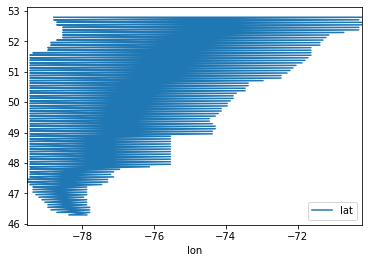

In [89]:
Region1i.plot("lon", "lat")

In [41]:
Region1i2 = Region1i[Region1i.time.dt.year!= 2011]
Region1i2

,lat,lon,time,tg_mean_p10,tg_mean_p50,tg_mean_p90
0,49.040680,-75.379089,1981-01-01,273.898773,274.023865,274.253326
2,49.040680,-75.379089,2041-01-01,276.468750,277.178040,278.122894
3,49.040680,-75.379089,2071-01-01,277.871460,279.937836,281.122986
4,49.040680,-75.295761,1981-01-01,273.867462,273.992706,274.221893
6,49.040680,-75.295761,2041-01-01,276.439148,277.145599,278.088867
...,...,...,...,...,...,...
6018,45.707481,-72.212547,2041-01-01,281.272827,281.877014,282.646820
6019,45.707481,-72.212547,2071-01-01,282.500183,284.547028,285.479523
6020,45.624149,-72.295883,1981-01-01,278.634430,278.719299,278.877808
6022,45.624149,-72.295883,2041-01-01,281.186798,281.807495,282.565216


In [42]:
Regionli3 = Region1i2.pivot_table(index=["lat","lon"], columns="time")



In [43]:
Regionli3

tg_mean_p10                         tg_mean_p50  \
time                  1981-01-01  2041-01-01  2071-01-01  1981-01-01   
lat       lon                                                          
45.624149 -72.295883  278.634430  281.186798  282.412170  278.719299   
45.707481 -72.462540  278.964081  281.533997  282.769836  279.048523   
          -72.379211  278.814484  281.383270  282.615662  278.901550   
          -72.295883  278.675201  281.242401  282.472656  278.761292   
          -72.212547  278.700073  281.272827  282.500183  278.787537   
...                          ...         ...         ...         ...   
49.040680 -74.962440  273.513458  276.093323  277.465698  273.643372   
          -74.879112  273.530212  276.111694  277.478546  273.661591   
          -74.795776  273.629944  276.212616  277.575836  273.762817   
          -74.712448  273.480133  276.064575  277.418152  273.615356   
          -74.629120  273.608978  276.193756  277.543732  273.745331   

                                             tg_mean_p90              \
time                  2041-01-01  2071-01-01  1981-01-01  2041-01-01   
lat       lon                                                          
45.624149 -72.295883  281.807495  284.463074  278.877808  282.565216   
45.707481 -72.462540  282.168335  284.844116  279.205597  282.909119   
          -72.379211  282.007782  284.679626  279.057922  282.757294   
          -72.295883  281.857239  284.527466  278.918762  282.616852   
          -72.212547  281.877014  284.547028  278.944733  282.646820   
...                          ...         ...         ...         ...   
49.040680 -74.962440  276.785187  279.544891  273.868530  277.724304   
          -74.879112  276.799744  279.561005  273.885406  277.736969   
          -74.795776  276.898468  279.661102  273.983795  277.833344   
          -74.712448  276.746399  279.509186  273.836456  277.679810   
          -74.629120  276.874420  279.638367  273.962982  277.805695   

                                  
time                  2071-01-01  
lat       lon                     
45.624149 -72.295883  285.393127  
45.707481 -72.462540  285.763397  
          -72.379211  285.602539  
          -72.295883  285.454529  
          -72.212547  285.479523  
...                          ...  
49.040680 -74.962440  280.730957  
          -74.879112  280.745178  
          -74.795776  280.842316  
          -74.712448  280.689575  
          -74.629120  280.815277  

[1506 rows x 9 columns]

In [44]:
Regionli3.columns = [year + "_tg_mean_p"+p
                     for p in ["10", "50", "90"]
                     for year in ["hist","2050", "2080"]]#"hist_tg_mean_p10", "2050_tg_mean_p10","2080_tg_mean_p10","hist_tg_mean_p50","tg_mean_p50","tg_mean_p90","tg_mean_p10","tg_mean_p50","tg_mean_p90",]

Regionli3

hist_tg_mean_p10  2050_tg_mean_p10  2080_tg_mean_p10  \
lat       lon                                                                
45.624149 -72.295883        278.634430        281.186798        282.412170   
45.707481 -72.462540        278.964081        281.533997        282.769836   
          -72.379211        278.814484        281.383270        282.615662   
          -72.295883        278.675201        281.242401        282.472656   
          -72.212547        278.700073        281.272827        282.500183   
...                                ...               ...               ...   
49.040680 -74.962440        273.513458        276.093323        277.465698   
          -74.879112        273.530212        276.111694        277.478546   
          -74.795776        273.629944        276.212616        277.575836   
          -74.712448        273.480133        276.064575        277.418152   
          -74.629120        273.608978        276.193756        277.543732   

                      hist_tg_mean_p50  2050_tg_mean_p50  2080_tg_mean_p50  \
lat       lon                                                                
45.624149 -72.295883        278.719299        281.807495        284.463074   
45.707481 -72.462540        279.048523        282.168335        284.844116   
          -72.379211        278.901550        282.007782        284.679626   
          -72.295883        278.761292        281.857239        284.527466   
          -72.212547        278.787537        281.877014        284.547028   
...                                ...               ...               ...   
49.040680 -74.962440        273.643372        276.785187        279.544891   
          -74.879112        273.661591        276.799744        279.561005   
          -74.795776        273.762817        276.898468        279.661102   
          -74.712448        273.615356        276.746399        279.509186   
          -74.629120        273.745331        276.874420        279.638367   

                      hist_tg_mean_p90  2050_tg_mean_p90  2080_tg_mean_p90  
lat       lon                                                               
45.624149 -72.295883        278.877808        282.565216        285.393127  
45.707481 -72.462540        279.205597        282.909119        285.763397  
          -72.379211        279.057922        282.757294        285.602539  
          -72.295883        278.918762        282.616852        285.454529  
          -72.212547        278.944733        282.646820        285.479523  
...                                ...               ...               ...  
49.040680 -74.962440        273.868530        277.724304        280.730957  
          -74.879112        273.885406        277.736969        280.745178  
          -74.795776        273.983795        277.833344        280.842316  
          -74.712448        273.836456        277.679810        280.689575  
          -74.629120        273.962982        277.805695        280.815277  

[1506 rows x 9 columns]

# TODO:
- Same process for the another scenario
- Get separate Dataframe for historic p50, put together both scenarios, get the mean by sum/2

## Merge data with polygons mask

In [45]:
Region1poly = pd.merge(Regionli3, dfpolyshape, on=["lat","lon"])


In [47]:
Region1poly

,lat,lon,hist_tg_mean_p10,2050_tg_mean_p10,2080_tg_mean_p10,hist_tg_mean_p50,2050_tg_mean_p50,2080_tg_mean_p50,hist_tg_mean_p90,2050_tg_mean_p90,2080_tg_mean_p90,OBJECTID,D_GENERAL,Shape_Leng,Shape_Area,ORIG_FID,geometry
0,45.624149,-72.295883,278.634430,281.186798,282.412170,278.719299,281.807495,284.463074,278.877808,282.565216,285.393127,1,Centre du Québec,2.503637e+06,8.760487e+10,0,"POLYGON ((-72.33755 45.61099, -72.33755 45.665..."
1,45.624149,-72.295883,278.634430,281.186798,282.412170,278.719299,281.807495,284.463074,278.877808,282.565216,285.393127,5,Secteur métropolitain et sud,1.123268e+06,2.330905e+10,4,"MULTIPOLYGON (((-72.33755 45.58248, -72.33755 ..."
2,45.707481,-72.462540,278.964081,281.533997,282.769836,279.048523,282.168335,284.844116,279.205597,282.909119,285.763397,1,Centre du Québec,2.503637e+06,8.760487e+10,0,"POLYGON ((-72.50420 45.70908, -72.50420 45.749..."
3,45.707481,-72.462540,278.964081,281.533997,282.769836,279.048523,282.168335,284.844116,279.205597,282.909119,285.763397,5,Secteur métropolitain et sud,1.123268e+06,2.330905e+10,4,"POLYGON ((-72.50420 45.66582, -72.50420 45.709..."
4,45.707481,-72.379211,278.814484,281.383270,282.615662,278.901550,282.007782,284.679626,279.057922,282.757294,285.602539,1,Centre du Québec,2.503637e+06,8.760487e+10,0,"POLYGON ((-72.42088 45.66582, -72.42088 45.749..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649,49.040680,-74.795776,273.629944,276.212616,277.575836,273.762817,276.898468,279.661102,273.983795,277.833344,280.842316,1,Centre du Québec,2.503637e+06,8.760487e+10,0,"POLYGON ((-74.83744 48.99901, -74.83744 49.082..."
1650,49.040680,-74.712448,273.480133,276.064575,277.418152,273.615356,276.746399,279.509186,273.836456,277.679810,280.689575,3,Nord-ouest,1.924555e+06,5.678854e+10,2,"POLYGON ((-74.75411 49.05345, -74.75411 49.053..."
1651,49.040680,-74.712448,273.480133,276.064575,277.418152,273.615356,276.746399,279.509186,273.836456,277.679810,280.689575,1,Centre du Québec,2.503637e+06,8.760487e+10,0,"MULTIPOLYGON (((-74.75411 48.99901, -74.75411 ..."
1652,49.040680,-74.629120,273.608978,276.193756,277.543732,273.745331,276.874420,279.638367,273.962982,277.805695,280.815277,3,Nord-ouest,1.924555e+06,5.678854e+10,2,"POLYGON ((-74.67078 49.03383, -74.67078 49.082..."


# Transform into a GeoJson File

## Transform into geodataframe

In [123]:
geometry = Region1poly["geometry"]
crs = {'init': "epsg:4326"}
gdf = GeoDataFrame(Region1poly, crs=crs, geometry=geometry)

# TODO: 
Make if condition for the name of the file based on the region name

In [124]:
gdf.to_file(Region1poly['NOM'].iloc[0]+"_"+variable+".json", driver="GeoJSON")
                    

### TODO: 

- Create "for loop" to create a DF for each group of regions
- Merge with the poly DF to get all the rest of the data (notably names of the regions) - Not necessary, just add a column with the name? - MAKE A DICTIONARY
- Beware: find a way to merge, given that poly doesn't have lat long
- Beware: there's no region 8 and 13. They are too small
- Merge with polyshape to create geojson:

dfpolyshape = from_geofeather('Grid-TerritoiresGuides.feather')
dftg2050TGp1 = pd.merge(dfC12050, dfpolyshape, on=["lat","lon"])
dftg2050TGp1
for tg in listTG2050p1:
    geometry = tg["geometry"]
    crs = {'init': "epsg:4326"}
    gdf2050p1 = GeoDataFrame(tg, crs=crs, geometry=geometry)
    print (tg['TER_GUIDE'].iloc[0])
    gdf2050p1.to_file(tg['TER_GUIDE'].iloc[0]+"_2050_tg_mean_annual_rcp85_10.json", driver="GeoJSON")
    

In [ ]:
%time dfper = perctiles.to_dataframe().dropna()
dfper